# Ammagamma: Final Project
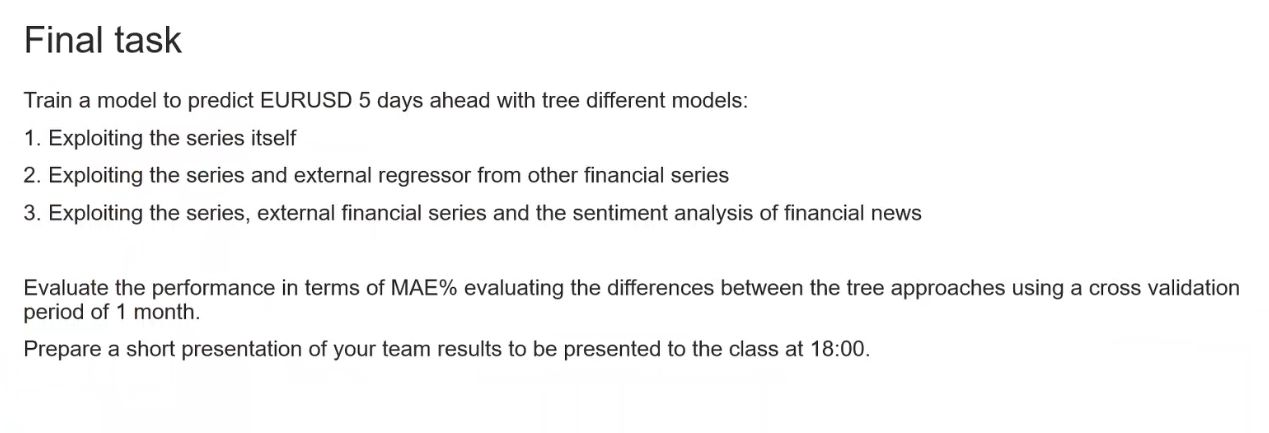

### Notebook Setup

Import Libraries

In [391]:
from prophet import Prophet
from datetime import date
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
import numpy as np
import seaborn as sns
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
#import requests
#from bs4 import BeautifulSoup

Global Variables

In [2]:
Ndays = 5

## Task 1: Forecast using Series only

### Download Data

#### Definition of starting and ending period

In [3]:
start = pd.to_datetime('2010-01-01')
end = date.today()

In [4]:
tickers_to_download = ['EURUSD=X']

#### Download tickers (only for Close prices)

In [5]:
forex_df_list = []

In [6]:
for ticker in tickers_to_download:
    
    # Download close prices ticker data betweeen chosen dates
    ts = yf.download(ticker, start, end)['Close']

    # Format ticker name
    ts = ts.rename(ticker.lower().split('=', 1)[0] + '_close')

    # Add ticker data to df_list
    forex_df_list.append(ts)

[*********************100%***********************]  1 of 1 completed


In [7]:
forex_df = pd.concat(forex_df_list, axis = 1)

In [15]:
y_col_name = "eurusd_close"

In [8]:
forex_df

,eurusd_close
Date,
2010-01-01,1.438994
2010-01-04,1.442398
2010-01-05,1.436596
2010-01-06,1.440403
2010-01-07,1.431803
...,...
2023-06-07,1.069805
2023-06-08,1.070744
2023-06-09,1.078272


### Data Exploration

#### Check missing values

In [9]:
forex_df[forex_df.isnull().any(axis = 1)]

,eurusd_close
Date,


In [10]:
forex_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3503 entries, 2010-01-01 to 2023-06-13
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   eurusd_close  3503 non-null   float64
dtypes: float64(1)
memory usage: 54.7 KB


#### Statistical Summary

In [11]:
forex_df.describe()

,eurusd_close
count,3503.000000
mean,1.202587
std,0.113946
min,0.959619
25%,1.113009
50%,1.176817
75%,1.306165
max,1.484406


In [16]:
fig = px.line(forex_df, y = y_col_name)
fig.show()

#### Taking the first difference

In [17]:
forex_rate_df = forex_df.pct_change(axis = "rows")
forex_rate_df.dropna(axis = 0, inplace = True)
forex_rate_df

,eurusd_close
Date,
2010-01-04,0.002366
2010-01-05,-0.004022
2010-01-06,0.002650
2010-01-07,-0.005971
2010-01-08,0.006499
...,...
2023-06-07,-0.001284
2023-06-08,0.000878
2023-06-09,0.007030


In [19]:
fig = px.line(forex_rate_df, y = y_col_name)
fig.show()

#### Standard Deviation for the Daily Exchange Rate Percentage Change

In [20]:
fig = px.histogram(forex_rate_df, x = y_col_name, marginal = "rug", hover_data = y_col_name, 
                    title=f'Distribution of {y_col_name} the std related to it is {np.round(forex_rate_df[y_col_name].std(), 3)}')
fig.show()

### Forecasting with Prophet

#### Formatting DF for Prophet

In order to forecast the SINGLE series in the future we need to:
1. ALWAYS add an additional column related to the y variable (in our scenario equal to usdeur_close) to df['y']
2. ALWAYS reset the index of the series and rename the column with the date in df['ds']

In [21]:
forex_df['ds'] = forex_df.index
forex_df['y'] = forex_df[y_col_name].values

In [22]:
forex_df.head()

,eurusd_close,ds,y
Date,,,
2010-01-01,1.438994,2010-01-01,1.438994
2010-01-04,1.442398,2010-01-04,1.442398
2010-01-05,1.436596,2010-01-05,1.436596
2010-01-06,1.440403,2010-01-06,1.440403
2010-01-07,1.431803,2010-01-07,1.431803


In [23]:
forex_df.tail()

,eurusd_close,ds,y
Date,,,
2023-06-07,1.069805,2023-06-07,1.069805
2023-06-08,1.070744,2023-06-08,1.070744
2023-06-09,1.078272,2023-06-09,1.078272
2023-06-12,1.075095,2023-06-12,1.075095
2023-06-13,1.076299,2023-06-13,1.076299


#### Train and Test split

In [24]:
train_window = ['2010-01-04', '2020-10-31']
test_window = ['2020-11-01', '2021-06-10']

In [25]:
train = forex_df[train_window[0]:train_window[1]]
test = forex_df[test_window[0]:test_window[1]]

#### Train Model

In [26]:
model = Prophet()

In [27]:
model.fit(train[['ds', 'y']])

17:49:48 - cmdstanpy - INFO - Chain [1] start processing
17:49:51 - cmdstanpy - INFO - Chain [1] done processing


#### Create the Future dataframe (required by Prophet)

In [308]:
future = model.make_future_dataframe(periods = Ndays, freq = "B")
#future = model.make_future_dataframe(periods = test.shape[0], freq = "B")

In [309]:
future.tail(10)

,ds
2815,2020-10-26
2816,2020-10-27
2817,2020-10-28
2818,2020-10-29
2819,2020-10-30
2820,2020-11-02
2821,2020-11-03
2822,2020-11-04
2823,2020-11-05
2824,2020-11-06


#### Initial Forecast

In [310]:
forecast = model.predict(future)
forecast_results = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(Ndays)
#forecast_results = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']] #.tail(Ndays)
forecast_results.set_index('ds', inplace = True)

In [311]:
forecast['trend'].tail(Ndays)

2820    1.120722
2821    1.120710
2822    1.120699
2823    1.120687
2824    1.120676
Name: trend, dtype: float64

In [312]:
forecast_results

,yhat,yhat_lower,yhat_upper
ds,,,
2020-11-02,1.133585,1.103412,1.162567
2020-11-03,1.132248,1.102228,1.161969
2020-11-04,1.130940,1.103587,1.158183
2020-11-05,1.129570,1.100912,1.158301
2020-11-06,1.128269,1.098529,1.156445


In [313]:
final_df_results = pd.merge(test[[y_col_name]], forecast_results[['yhat']], left_index=True, right_index=True, how='inner')

In [314]:
final_df_results

,eurusd_close,yhat
2020-11-02,1.164212,1.133585
2020-11-03,1.164280,1.132248
2020-11-04,1.176221,1.130940
2020-11-05,1.173268,1.129570
2020-11-06,1.181754,1.128269


#### Model Evaluation

Error function

In [315]:
# Errors
def errors(test, preds, verbose = True):
    percentiles = [5, 25, 50, 75, 95]
    elementwise_mae = np.absolute(np.subtract(preds, test))

    # Mean MAE
    mean_mae = sum(elementwise_mae) / len(test)
    print(f"Mean MAE: {mean_mae:.2f}")
    percent_mae = sum(elementwise_mae) / sum(test)
    print(f"MAE%: {percent_mae * 100:.2f}%")

    # RMSE
    rmse = np.sqrt(np.mean(np.power(np.subtract(preds, test), 2)))
    print(f"RMSE: {rmse:.2f}")

    # Bias
    bias = np.mean(np.subtract(preds, test))
    print(f"Bias: {bias:.2f}\n")

    if verbose:
        # MAE distribution
        distr_mae = []
        for perc in percentiles:
            temp_mae = np.percentile(elementwise_mae, perc)
            distr_mae.append(temp_mae)
            print(f"{perc}th percetile MAE: {temp_mae:.2f}")

        # Plot MAE distribution
        plt.figure(figsize=(8, 8))
        plt.title('MAE distribution')
        plt.xlabel('MAE')
        plt.ylabel('Count')

        # Plot distribution
        plt.hist(elementwise_mae, bins=30)

        # Plot mean MAE
        plt.axvline(x=mean_mae, label='Mean MAE', c='r', linestyle='-')

        # Plot percentiles
        line_types = [':', '-.', '--', '-.', ':']
        for xc, lt, p in zip(distr_mae, line_types, percentiles):
            plt.axvline(x=xc, label='{}th percentile MAE'.format(p), c='r', linestyle=lt)
        plt.legend()
        plt.show()


Compute errors

Mean MAE: 0.04
MAE%: 3.50%
RMSE: 0.04
Bias: -0.04

5th percetile MAE: 0.03
25th percetile MAE: 0.03
50th percetile MAE: 0.04
75th percetile MAE: 0.05
95th percetile MAE: 0.05


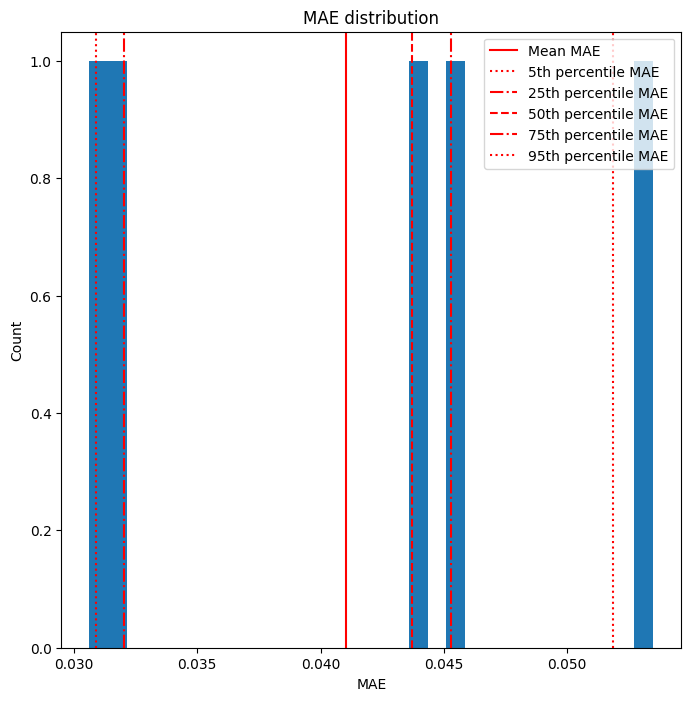

In [316]:
errors(final_df_results[y_col_name].values, final_df_results['yhat'].values)

Explore the trend components of the fitted model

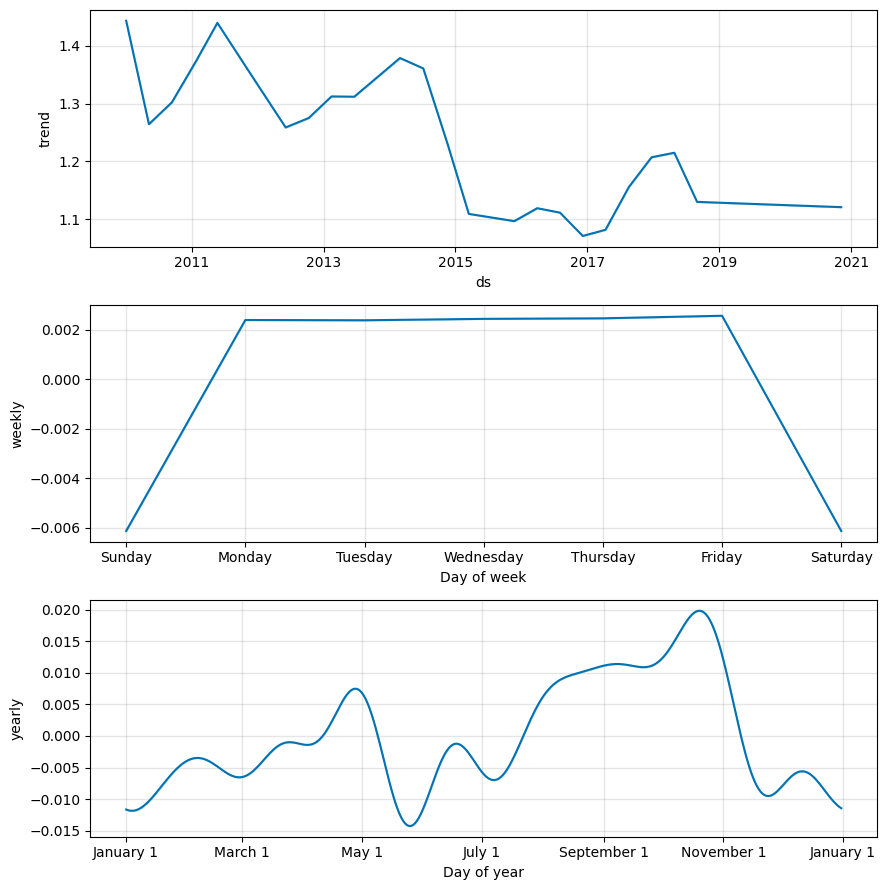

In [317]:
fig = model.plot_components(forecast)

In [318]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=final_df_results.index, y=final_df_results[y_col_name], mode='lines+markers', name='Real Values'))
fig.add_trace(go.Scatter(x=final_df_results.index, y=final_df_results['yhat'], mode='lines+markers', name='Predicted Values'))
fig.show()

#### Baseline "Rolling Average" Model

In [319]:
print("Prophet Model")
errors(final_df_results[y_col_name].values, final_df_results['yhat'].values, False)

# Compare to Baseline Rolling Avg Models
for rollback in range(1, Ndays):
    print(f"Rollback Business Days: {rollback}")
    final_df_results['yhat_rolling'] = final_df_results[y_col_name].rolling(rollback).mean()
    errors(final_df_results.dropna()['yhat_rolling'].values, final_df_results.dropna()['yhat'].values, False)

Prophet Model
Mean MAE: 0.04
MAE%: 3.50%
RMSE: 0.04
Bias: -0.04

Rollback Business Days: 1
Mean MAE: 0.04
MAE%: 3.50%
RMSE: 0.04
Bias: -0.04

Rollback Business Days: 2
Mean MAE: 0.04
MAE%: 3.54%
RMSE: 0.04
Bias: -0.04

Rollback Business Days: 3
Mean MAE: 0.04
MAE%: 3.63%
RMSE: 0.04
Bias: -0.04

Rollback Business Days: 4
Mean MAE: 0.04
MAE%: 3.65%
RMSE: 0.04
Bias: -0.04



The sophisicated Prophet model does not perform better than the naive model (y[t] = y[t-1]) and not much better than the longer rolling averages upto the future forecast period - 1 (4 days).

#### Cross Validation

##### CV Window

Over the last 1 month + 5 days of data: performs 30 cv trains & tests

In [384]:
cutoffs = train['ds'][-35:-5]
df_cv = cross_validation(model, period='1 days', horizon = '5 days', cutoffs=cutoffs)

  0%|          | 0/30 [00:00<?, ?it/s]

18:49:34 - cmdstanpy - INFO - Chain [1] start processing
18:49:37 - cmdstanpy - INFO - Chain [1] done processing
18:49:37 - cmdstanpy - INFO - Chain [1] start processing
18:49:40 - cmdstanpy - INFO - Chain [1] done processing
18:49:40 - cmdstanpy - INFO - Chain [1] start processing
18:49:43 - cmdstanpy - INFO - Chain [1] done processing
18:49:43 - cmdstanpy - INFO - Chain [1] start processing
18:49:45 - cmdstanpy - INFO - Chain [1] done processing
18:49:46 - cmdstanpy - INFO - Chain [1] start processing
18:49:48 - cmdstanpy - INFO - Chain [1] done processing
18:49:49 - cmdstanpy - INFO - Chain [1] start processing
18:49:51 - cmdstanpy - INFO - Chain [1] done processing
18:49:51 - cmdstanpy - INFO - Chain [1] start processing
18:49:54 - cmdstanpy - INFO - Chain [1] done processing
18:49:55 - cmdstanpy - INFO - Chain [1] start processing
18:49:57 - cmdstanpy - INFO - Chain [1] done processing
18:49:58 - cmdstanpy - INFO - Chain [1] start processing
18:50:00 - cmdstanpy - INFO - Chain [1]

In [386]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-09-15,1.120458,1.092903,1.148023,1.187000,2020-09-14
1,2020-09-16,1.120204,1.092375,1.146811,1.184441,2020-09-14
2,2020-09-17,1.119915,1.089374,1.148910,1.180345,2020-09-14
3,2020-09-18,1.119742,1.090675,1.147092,1.184820,2020-09-14
4,2020-09-16,1.121071,1.094423,1.151021,1.184441,2020-09-15


##### MAE% Plot

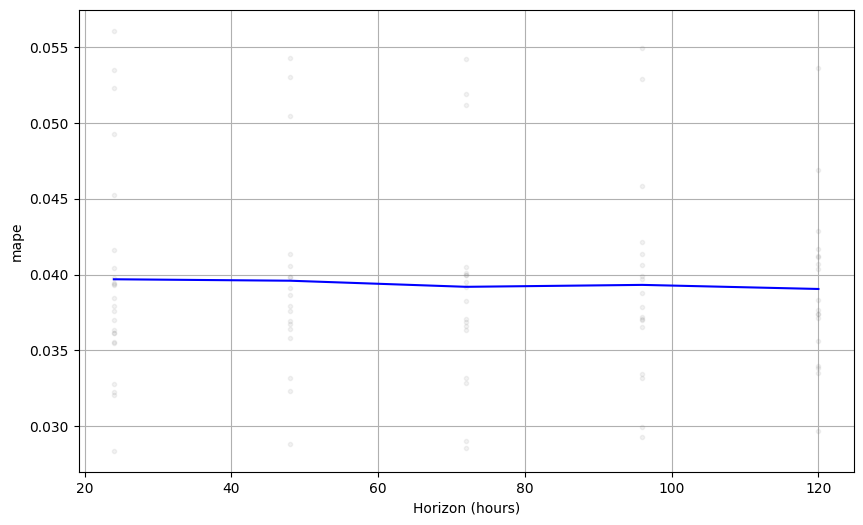

In [388]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

## Task 2: Forecast using Series plus External Regressors

### Acquire External Regressors

#### Download external regressors

In [397]:
def get_data_from_googledrive(url, date_col_name):
    file_id = url.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?id=' + file_id
    df = pd.read_csv(dwn_url, parse_dates=[date_col_name])
    return df

In [398]:
url_extra = 'https://drive.google.com/file/d/1CT91MvzT2-WLK6rTdDu4-vBdj0kyfDP5/view?usp=sharing'
url_covid = 'https://drive.google.com/file/d/1ZlwZtSdtxlTlP2RUZtYjqpVSiaXMEzXO/view?usp=sharing'

In [399]:
econ_df = get_data_from_googledrive(url_extra, 'DATE')
covid_df = get_data_from_googledrive(url_covid, 'date')

In [400]:
econ_df.head()

,DATE,CPIAUCSL,GDP,T10YIE
0,1947-01-01,21.48,243.164,NaN
1,1947-01-02,21.48,243.164,NaN
2,1947-01-03,21.48,243.164,NaN
3,1947-01-04,21.48,243.164,NaN
4,1947-01-05,21.48,243.164,NaN


In [401]:
covid_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


#### Extract relevant external time series

##### Economic external regressors

In [402]:
econ_df.set_index('DATE', inplace = True)
econ_map_dict = {'CPIAUCSL':'consumer_price_index', 'GDP':'GDP_US', 'T10YIE':'inflation'}
econ_df = econ_df.rename(columns = econ_map_dict)

In [403]:
econ_df.head()

,consumer_price_index,GDP_US,inflation
DATE,,,
1947-01-01,21.48,243.164,NaN
1947-01-02,21.48,243.164,NaN
1947-01-03,21.48,243.164,NaN
1947-01-04,21.48,243.164,NaN
1947-01-05,21.48,243.164,NaN


In [404]:
econ_df.tail()

,consumer_price_index,GDP_US,inflation
DATE,,,
2021-05-16,266.832,22048.894,2.51
2021-05-17,266.832,22048.894,2.54
2021-05-18,266.832,22048.894,2.52
2021-05-19,266.832,22048.894,2.48
2021-05-20,266.832,22048.894,2.41


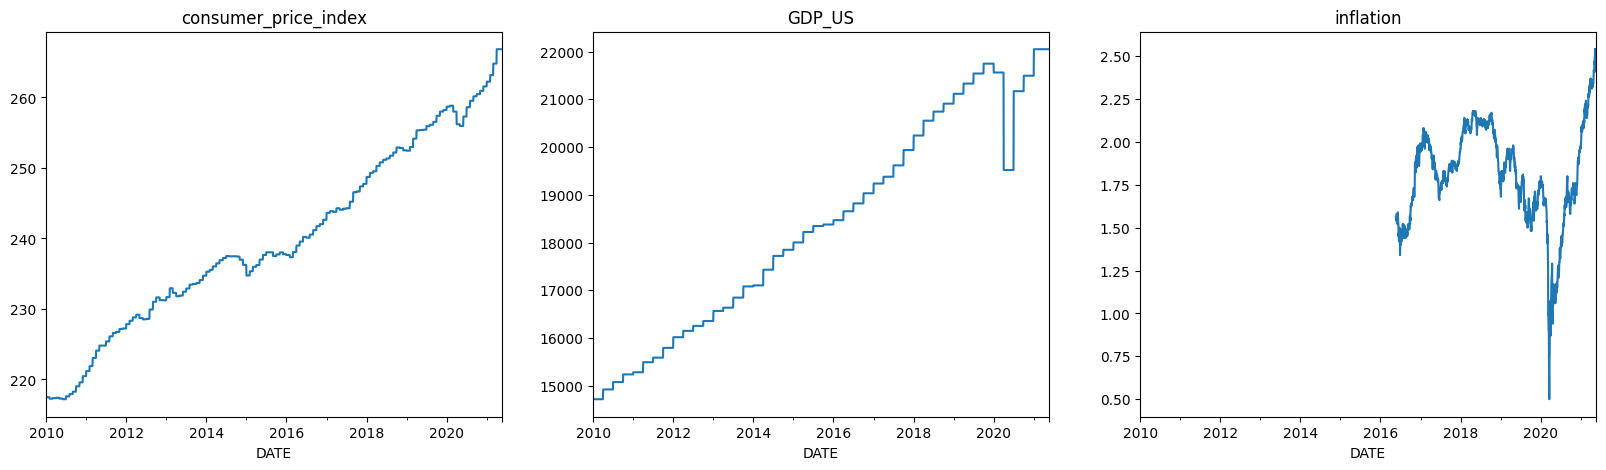

In [405]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
for idx, col in enumerate(econ_df):
  econ_df[col].loc[forex_df.index[0]:forex_df.index[-1]].plot(ax=ax[idx])
  ax[idx].set_title(col)

##### Covid external regressors (North America and Europe)

In [406]:
# group data for each continent and sum the number of new cases
covid_df_grouped = covid_df.groupby(['continent','date']).agg({'new_cases':'sum'})

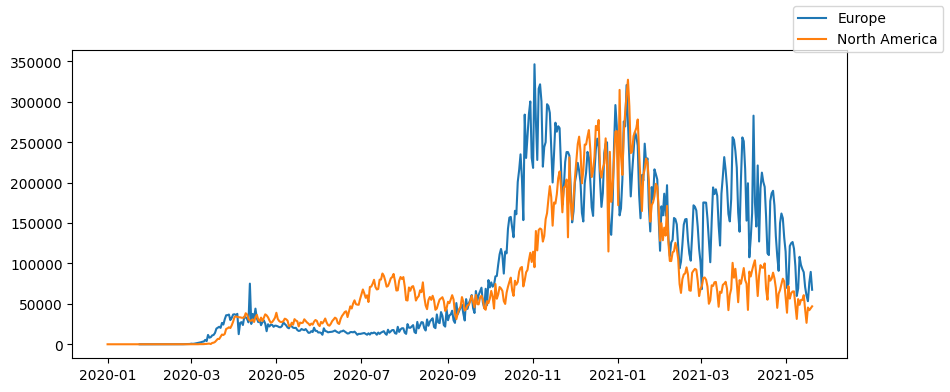

In [407]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(covid_df_grouped.loc['Europe'], label='Europe')
ax.plot(covid_df_grouped.loc['North America'], label='North America')
fig.legend()

#### Shift extra regressors by number of forecasted days

In [408]:
econ_df.loc[train_window[0]:test_window[1]].isnull().any(axis = 1)

DATE
2010-01-04     True
2010-01-05     True
2010-01-06     True
2010-01-07     True
2010-01-08     True
              ...  
2021-05-16    False
2021-05-17    False
2021-05-18    False
2021-05-19    False
2021-05-20    False
Length: 4155, dtype: bool

In [409]:
econ_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27169 entries, 1947-01-01 to 2021-05-20
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   consumer_price_index  27169 non-null  float64
 1   GDP_US                27169 non-null  float64
 2   inflation             1827 non-null   float64
dtypes: float64(3)
memory usage: 1.8 MB


In [410]:
econ_df.tail(10)

,consumer_price_index,GDP_US,inflation
DATE,,,
2021-05-11,266.832,22048.894,2.53
2021-05-12,266.832,22048.894,2.54
2021-05-13,266.832,22048.894,2.51
2021-05-14,266.832,22048.894,2.51
2021-05-15,266.832,22048.894,2.51
2021-05-16,266.832,22048.894,2.51
2021-05-17,266.832,22048.894,2.54
2021-05-18,266.832,22048.894,2.52
2021-05-19,266.832,22048.894,2.48


In [411]:
econ_df_shifted = econ_df.shift(periods = 0)

In [412]:
econ_df_shifted.tail(10)

,consumer_price_index,GDP_US,inflation
DATE,,,
2021-05-11,266.832,22048.894,2.53
2021-05-12,266.832,22048.894,2.54
2021-05-13,266.832,22048.894,2.51
2021-05-14,266.832,22048.894,2.51
2021-05-15,266.832,22048.894,2.51
2021-05-16,266.832,22048.894,2.51
2021-05-17,266.832,22048.894,2.54
2021-05-18,266.832,22048.894,2.52
2021-05-19,266.832,22048.894,2.48


In [413]:
covid_df_1 = covid_df_grouped.loc["North America"].rename(columns = {"new_cases":"covid_US"})
covid_df_1["covid_EU"] = covid_df_grouped.loc["Europe"].rename(columns = {"new_cases":"covid_EU"})

In [414]:
covid_df_1.tail(10)

,covid_US,covid_EU
date,,
2021-05-11,48803.0,108217.0
2021-05-12,54844.0,98176.0
2021-05-13,54772.0,93044.0
2021-05-14,60795.0,89157.0
2021-05-15,42893.0,70639.0
2021-05-16,26537.0,60183.0
2021-05-17,45487.0,53323.0
2021-05-18,42170.0,76497.0
2021-05-19,44661.0,89586.0


In [415]:
covid_df_1_shifted = covid_df_1.shift(periods = Ndays)

In [416]:
covid_df_1_shifted.tail(10)

,covid_US,covid_EU
date,,
2021-05-11,65359.0,126528.0
2021-05-12,65436.0,118314.0
2021-05-13,48282.0,96615.0
2021-05-14,31364.0,59796.0
2021-05-15,55867.0,69099.0
2021-05-16,48803.0,108217.0
2021-05-17,54844.0,98176.0
2021-05-18,54772.0,93044.0
2021-05-19,60795.0,89157.0


#### Correlations

Merge data into single dataframe

In [417]:
forex_df.tail()

,eurusd_close,ds,y
Date,,,
2023-06-07,1.069805,2023-06-07,1.069805
2023-06-08,1.070744,2023-06-08,1.070744
2023-06-09,1.078272,2023-06-09,1.078272
2023-06-12,1.075095,2023-06-12,1.075095
2023-06-13,1.076299,2023-06-13,1.076299


In [418]:
econ_df_shifted.tail()

,consumer_price_index,GDP_US,inflation
DATE,,,
2021-05-16,266.832,22048.894,2.51
2021-05-17,266.832,22048.894,2.54
2021-05-18,266.832,22048.894,2.52
2021-05-19,266.832,22048.894,2.48
2021-05-20,266.832,22048.894,2.41


In [419]:
forex_df_er = forex_df.merge(econ_df_shifted, left_index = True, right_index = True, how = "left")
forex_df_er = forex_df_er.merge(covid_df_1_shifted, left_index = True, right_index = True, how = "left")

forex_df_er = forex_df_er.merge(covid_df_grouped.loc["North America"].rename(columns = {"new_cases":"covid_US"}), left_index = True, right_index = True, how = "left")
forex_df_er = forex_df_er.merge(covid_df_grouped.loc["Europe"].rename(columns = {"new_cases":"covid_EU"}), left_index = True, right_index = True, how = "left")
forex_df_er["covid_US"] = forex_df_er["covid_US"].fillna(0)
forex_df_er["covid_EU"] = forex_df_er["covid_EU"].fillna(0)

In [420]:
forex_df_er.tail(10)

,eurusd_close,ds,y,consumer_price_index,GDP_US,inflation,covid_US,covid_EU
Date,,,,,,,,
2023-05-31,1.073307,2023-05-31,1.073307,NaN,NaN,NaN,NaN,NaN
2023-06-01,1.069519,2023-06-01,1.069519,NaN,NaN,NaN,NaN,NaN
2023-06-02,1.076079,2023-06-02,1.076079,NaN,NaN,NaN,NaN,NaN
2023-06-05,1.069862,2023-06-05,1.069862,NaN,NaN,NaN,NaN,NaN
2023-06-06,1.071180,2023-06-06,1.071180,NaN,NaN,NaN,NaN,NaN
2023-06-07,1.069805,2023-06-07,1.069805,NaN,NaN,NaN,NaN,NaN
2023-06-08,1.070744,2023-06-08,1.070744,NaN,NaN,NaN,NaN,NaN
2023-06-09,1.078272,2023-06-09,1.078272,NaN,NaN,NaN,NaN,NaN
2023-06-12,1.075095,2023-06-12,1.075095,NaN,NaN,NaN,NaN,NaN


Correlation heatmap

<AxesSubplot: >

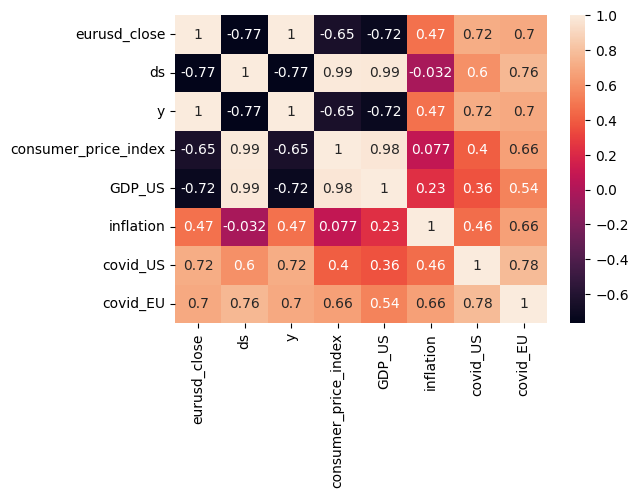

In [421]:
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(forex_df_er.corr(), annot=True, ax=ax)

<AxesSubplot: >

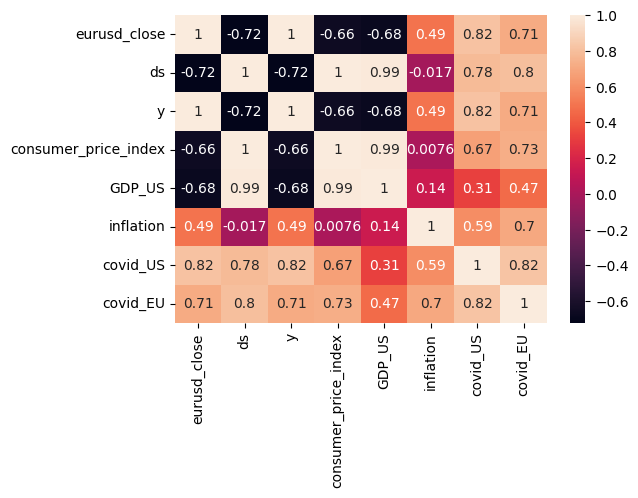

In [422]:
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(forex_df_er.corr("spearman"), annot=True, ax=ax)

### Forecast with Prophet using External Regressors

#### Train and Test Splits

In [423]:
forex_df_er = forex_df_er.dropna()
train_er = forex_df_er[train_window[0]:train_window[1]]
test_er = forex_df_er[test_window[0]:test_window[1]]

In [424]:
train_er.tail(10)

,eurusd_close,ds,y,consumer_price_index,GDP_US,inflation,covid_US,covid_EU
Date,,,,,,,,
2020-10-19,1.171550,2020-10-19,1.171550,260.462,21494.731,1.71,71229.0,142979.0
2020-10-20,1.176886,2020-10-20,1.176886,260.462,21494.731,1.72,77255.0,156681.0
2020-10-21,1.182984,2020-10-21,1.182984,260.462,21494.731,1.74,82479.0,157579.0
2020-10-22,1.185396,2020-10-22,1.185396,260.462,21494.731,1.76,66605.0,144083.0
2020-10-23,1.181502,2020-10-23,1.181502,260.462,21494.731,1.75,59889.0,132439.0
2020-10-26,1.184848,2020-10-26,1.184848,260.462,21494.731,1.72,77054.0,200851.0
2020-10-27,1.180944,2020-10-27,1.180944,260.462,21494.731,1.71,89694.0,215582.0
2020-10-28,1.178411,2020-10-28,1.178411,260.462,21494.731,1.70,94535.0,235023.0
2020-10-29,1.174867,2020-10-29,1.174867,260.462,21494.731,1.71,95639.0,205265.0


In [425]:
# Shift is confirmed on the external regressors
econ_df.loc[train_er.index[-10:]]

,consumer_price_index,GDP_US,inflation
Date,,,
2020-10-19,260.462,21494.731,1.71
2020-10-20,260.462,21494.731,1.72
2020-10-21,260.462,21494.731,1.74
2020-10-22,260.462,21494.731,1.76
2020-10-23,260.462,21494.731,1.75
2020-10-26,260.462,21494.731,1.72
2020-10-27,260.462,21494.731,1.71
2020-10-28,260.462,21494.731,1.70
2020-10-29,260.462,21494.731,1.71


#### Model

In [426]:
model_er = Prophet(growth = "linear", n_changepoints = 7, changepoint_prior_scale = 0.05)
model_er.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_er.add_seasonality(name='weekly', period=7, fourier_order=15)

Add extra regressors

In [427]:
extra_regressors = ['consumer_price_index', 'GDP_US','inflation', 'covid_US', 'covid_EU']
for reg in extra_regressors:
  model_er.add_regressor(name = reg, mode = 'additive')

In [428]:
model_er.fit(train_er)

19:14:18 - cmdstanpy - INFO - Chain [1] start processing
19:14:18 - cmdstanpy - INFO - Chain [1] done processing


#### Create Future dataframe

In [429]:
future_er = model_er.make_future_dataframe(Ndays, freq='B')
#future_er = model_er.make_future_dataframe(test_er.shape[0], freq='B')
forecast_er = model_er.predict(future_er.merge(forex_df_er[extra_regressors], left_on='ds', right_index=True, how='left').fillna(method='pad'))

forecast_results_er = forecast_er[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_results_er.set_index('ds', inplace=True)

In [430]:
final_df_results_er = pd.merge(test_er[y_col_name], forecast_results_er[['yhat']], left_index=True, right_index=True)

In [431]:
final_df_results_er.tail()

,eurusd_close,yhat
2020-11-02,1.164212,1.190169
2020-11-03,1.164280,1.192923
2020-11-04,1.176221,1.192288
2020-11-05,1.173268,1.179142
2020-11-06,1.181754,1.167918


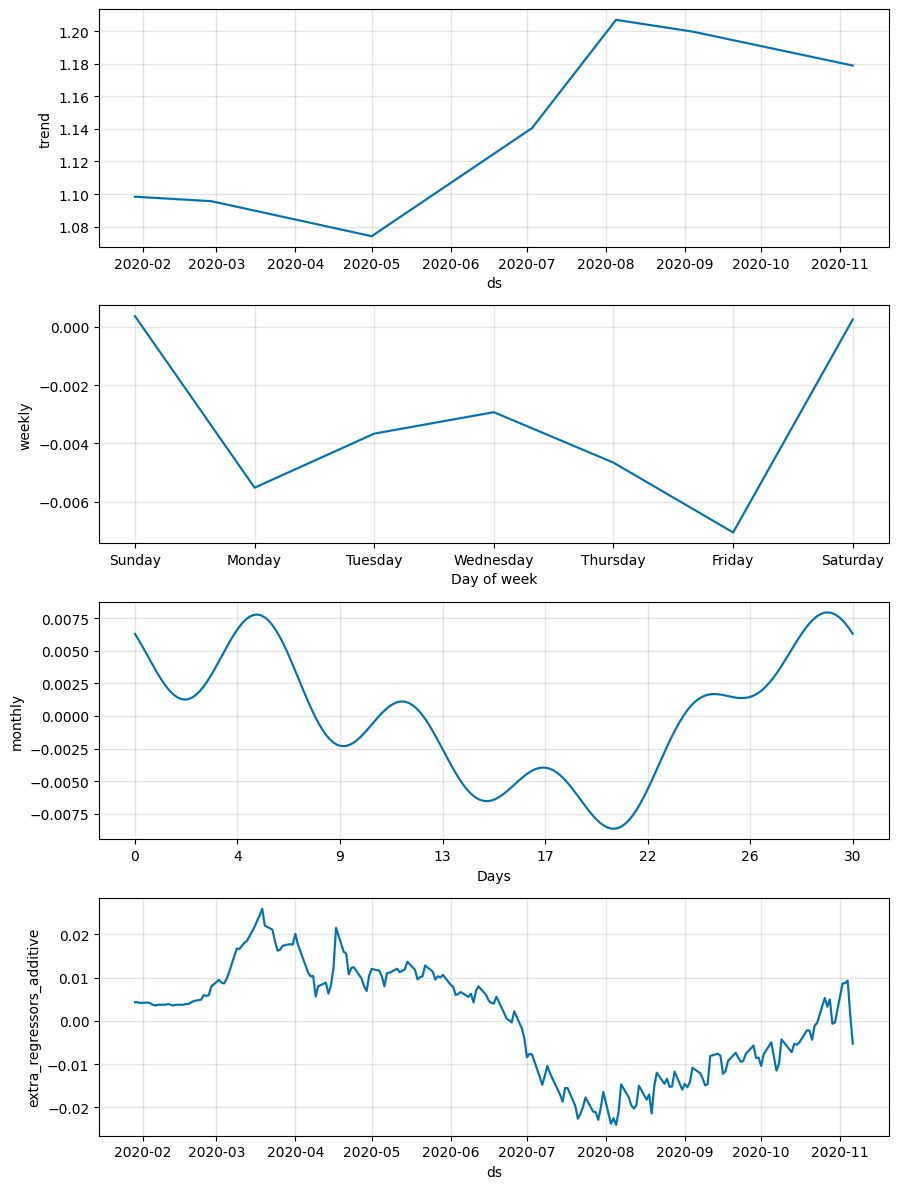

In [432]:
fig = model_er.plot_components(forecast_er)

#### Explore Roles and Weights for the Extra Regressors

<AxesSubplot: xlabel='ds'>

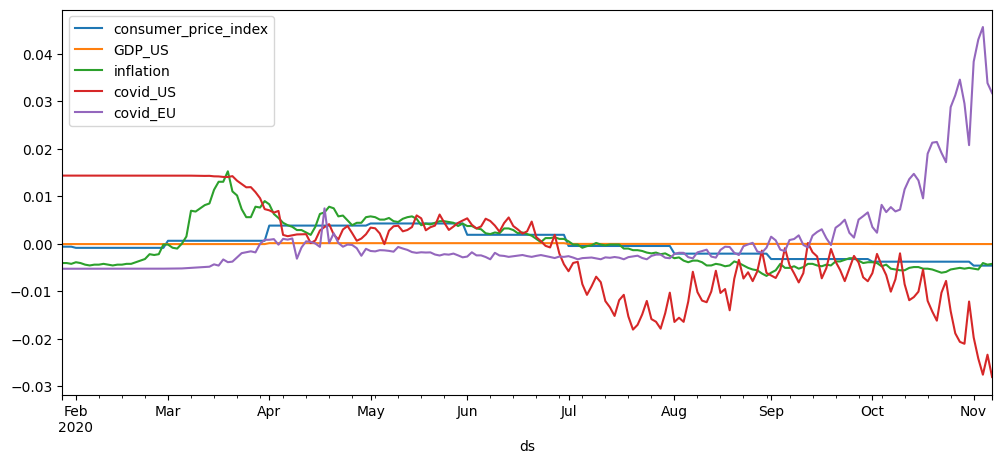

In [433]:
fig, ax = plt.subplots(figsize=(12,5))
forecast_er.set_index('ds')[extra_regressors].plot(ax=ax)

In [434]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=final_df_results_er.index, y=final_df_results_er[y_col_name], mode='lines+markers', name='Real Values'))
fig.add_trace(go.Scatter(x=final_df_results_er.index, y=final_df_results_er['yhat'], mode='lines+markers', name='Predicted Values'))
fig.show()

#### Model Evalation

Mean MAE: 0.02
MAE%: 1.54%
RMSE: 0.02
Bias: 0.01

5th percetile MAE: 0.01
25th percetile MAE: 0.01
50th percetile MAE: 0.02
75th percetile MAE: 0.03
95th percetile MAE: 0.03


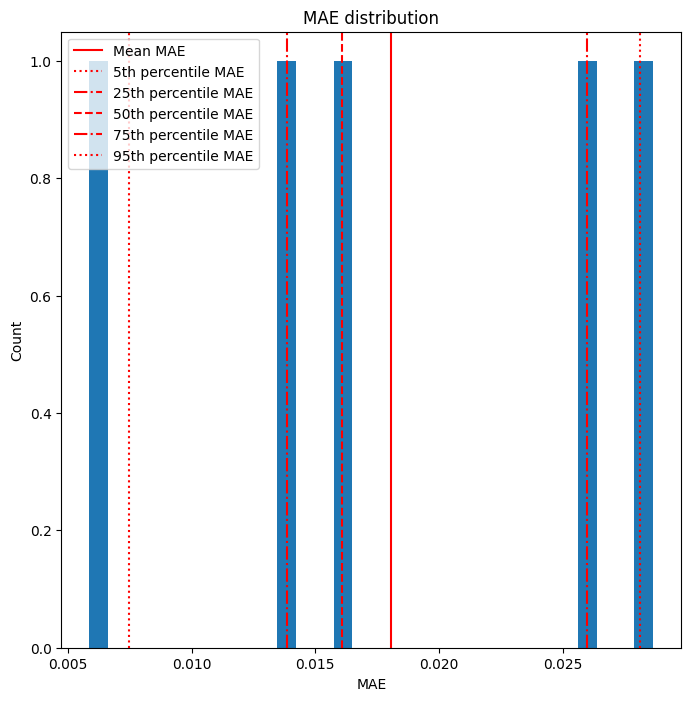

In [435]:
errors(final_df_results_er[y_col_name].values, final_df_results_er["yhat"].values)

#### Cross Validation

##### CV Window

In [436]:
cutoffs_er = train_er['ds'][-35:-5]
df_cv_er = cross_validation(model_er, period='1 days', horizon = '5 days', cutoffs=cutoffs_er)

  0%|          | 0/30 [00:00<?, ?it/s]

19:14:21 - cmdstanpy - INFO - Chain [1] start processing
19:14:21 - cmdstanpy - INFO - Chain [1] done processing
19:14:21 - cmdstanpy - INFO - Chain [1] start processing
19:14:21 - cmdstanpy - INFO - Chain [1] done processing
19:14:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
19:14:21 - cmdstanpy - INFO - Chain [1] start processing
19:14:22 - cmdstanpy - INFO - Chain [1] done processing
19:14:22 - cmdstanpy - INFO - Chain [1] start processing
19:14:22 - cmdstanpy - INFO - Chain [1] done processing
19:14:22 - cmdstanpy - INFO - Chain [1] start processing
19:14:23 - cmdstanpy - INFO - Chain [1] done processing
19:14:23 - cmdstanpy - INFO - Chain [1] start processing
19:14:23 - cmdstanpy - INFO - Chain [1] done processing
19:14:23 - cmdstanpy - INFO - Chain [1] start processing
19:14:23 - cmdstanpy - INFO - Chain [1] done processing
19:14:24 - cmdstanpy - INFO - Chain [1] start processing
19:14:

##### MAE% Plot

Better performance in term of MAE% (about 4 times less)

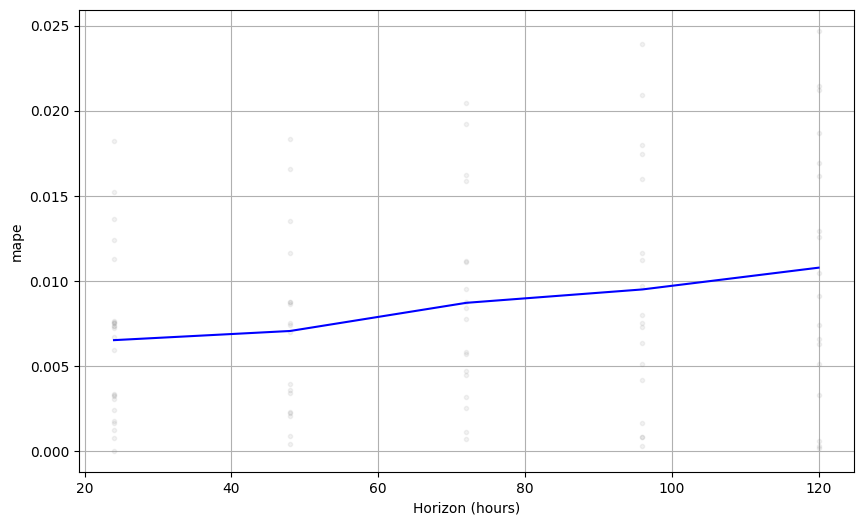

In [437]:
fig = plot_cross_validation_metric(df_cv_er, metric='mape')

## Task 3: Integrating Sentiment Analysis from Financial News